# Machine Learning Model for the Planetary Albedo

### Import necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# H2O Auto ml
import h2o
from h2o.automl import H2OAutoML

# Linear regression
from sklearn.linear_model import LinearRegression

# XGBoost and Bates hiperparameter optimization
import numpy as np
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings; warnings.simplefilter('ignore')

C:\Users\marti\anaconda3\envs\gsoc\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Task 1. Predicting the Lunar Albedo based on Chemical Composition

### Data visualisation

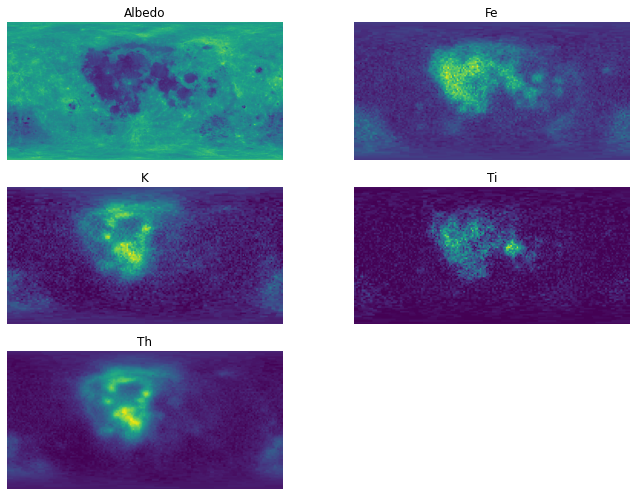

In [2]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 2
  
# reading images
albedo = pd.read_csv(r"Albedo_Map.csv", header=None)
fe = pd.read_csv(r"LPFe_Map.csv", header=None)
k = pd.read_csv(r"LPK_Map.csv", header=None)
ti = pd.read_csv(r"LPTi_Map.csv", header=None)
th = pd.read_csv(r"LPTh_Map.csv", header=None)
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(albedo)
plt.axis('off')
plt.title("Albedo")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(fe)
plt.axis('off')
plt.title("Fe")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(k)
plt.axis('off')
plt.title("K")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(ti)
plt.axis('off')
plt.title("Ti")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(th)
plt.axis('off')
plt.title("Th")

fig.tight_layout()

plt.show()

    After visualizing the images it is very likely that there is spatial correlation between the data. From my experience the best way to introduce spatial correlation in the modeling is by means of k nearest neighbors, but the suggested data splitting method for model training makes this methodology not applicable, since there are no neighbors to include as input in the testing part.
    Because of this I will include the position of each of the data with two coordinates as rows and columns to see if there is any spatial correlation in the simplest way possible. 

### Data preparation and visualization

In [4]:
# Divide images for train/test process
left_albedo = albedo.iloc[:,0:360]
right_albedo = albedo.iloc[:,360:720]

left_fe = fe.iloc[:,0:360]
right_fe = fe.iloc[:,360:720]

left_k = k.iloc[:,0:360]
right_k = k.iloc[:,360:720]

left_ti = ti.iloc[:,0:360]
right_ti = ti.iloc[:,360:720]

left_th = th.iloc[:,0:360]
right_th = th.iloc[:,360:720]

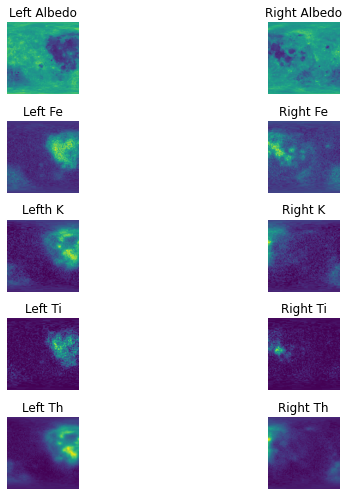

In [5]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 5
columns = 2
  
# First image
fig.add_subplot(rows, columns, 1)
  
plt.imshow(left_albedo)
plt.axis('off')
plt.title("Left Albedo")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(right_albedo)
plt.axis('off')
plt.title("Right Albedo")

# Second image
fig.add_subplot(rows, columns, 3)
  
plt.imshow(left_fe)
plt.axis('off')
plt.title("Left Fe")
  
fig.add_subplot(rows, columns, 4)
  
plt.imshow(right_fe)
plt.axis('off')
plt.title("Right Fe")

# Third image
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(left_k)
plt.axis('off')
plt.title("Lefth K")
  
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(right_k)
plt.axis('off')
plt.title("Right K")
  
# Fourth image
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(left_ti)
plt.axis('off')
plt.title("Left Ti")

fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(right_ti)
plt.axis('off')
plt.title("Right Ti")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(left_th)
plt.axis('off')
plt.title("Left Th")

fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(right_th)
plt.axis('off')
plt.title("Right Th")

fig.tight_layout()

plt.show()

### Train/Test data creation

In [6]:
a = {'albedo': pd.Series(left_albedo.values.ravel('F'))}

b = {'fe': pd.Series(left_fe.values.ravel('F')),
         'k': pd.Series(left_k.values.ravel('F')),
         'ti': pd.Series(left_ti.values.ravel('F')),
     'th': pd.Series(left_th.values.ravel('F'))
}
                    
y_train = pd.DataFrame(data=a)
x_train = pd.DataFrame(data=b)

x_train_sc = pd.DataFrame(data=b)

c = {'albedo': pd.Series(right_albedo.values.ravel('F'))}

d = {'fe': pd.Series(right_fe.values.ravel('F')),
         'k': pd.Series(right_k.values.ravel('F')),
         'ti': pd.Series(right_ti.values.ravel('F')),
     'th': pd.Series(right_th.values.ravel('F'))
    }

y_test = pd.DataFrame(data=c)
x_test = pd.DataFrame(data=d)

x_test_sc = pd.DataFrame(data=d)

train = y_train.join(x_train)

test = y_test.join(x_test)

With the following loop I include the location in to each data frame.

In [7]:
from itertools import cycle

num_cycle = cycle(range(0,360,1))
train['x'] = [next(num_cycle) for num in range(len(train))]
x_train_sc['x'] = [next(num_cycle) for num in range(len(train))]

num_cycle = cycle(range(0,360,1))
train['y'] = [next(num_cycle) for num in range(len(train))]
x_train_sc['y'] = [next(num_cycle) for num in range(len(train))]

num_cycle = cycle(range(360,720,1))
test['x'] = [next(num_cycle) for num in range(len(train))]
x_test_sc['x'] = [next(num_cycle) for num in range(len(train))]

num_cycle = cycle(range(0,360,1))
test['y'] = [next(num_cycle) for num in range(len(train))]
x_test_sc['y'] = [next(num_cycle) for num in range(len(train))]

In [8]:
cols = ["Algorithm", "R2", "MSE", "RMSE", "EVS", "MAE"]
results = pd.DataFrame(columns = cols)

### Auto machine learning inluding spatial covariables

* When starting to model the data it is always a good habit to select covariates as well as to see which algorithms fit best in the database, to use self machine learning models.

In [42]:
# Start the H2O cluster (locally)
# h2o.init()

In [8]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_models=10,
                nfolds=5,
          include_algos = ["GLM", "DRF","GBM"], # "DeepLearning"
          stopping_metric = "rmse",
                seed=1,
          max_runtime_secs=600)

In [9]:
h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [87]:
# aml.train(x=['fe', 'k', 'ti', 'th','x','y'], 
#           y="albedo",
#           training_frame=h2o_train)

#### Leaderboard

In [33]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_2_AutoML_2_20220316_95241,0.000204873,0.0143134,0.000204873,0.0105276,0.0111532
XRT_2_AutoML_2_20220316_95241,0.000207705,0.014412,0.000207705,0.0106096,0.0112315
GBM_grid_2_AutoML_2_20220316_95241_model_1,0.000224238,0.0149746,0.000224238,0.0110531,0.0116864
GBM_grid_1_AutoML_1_20220316_91433_model_1,0.000247024,0.015717,0.000247024,0.011616,0.0122686
DRF_1_AutoML_1_20220316_91433,0.000249249,0.0157876,0.000249249,0.0116736,0.0123054
GBM_9_AutoML_2_20220316_95241,0.000251381,0.015855,0.000251381,0.0117794,0.0123471
XRT_1_AutoML_1_20220316_91433,0.000255254,0.0159767,0.000255254,0.0118364,0.0124478
GBM_6_AutoML_2_20220316_95241,0.000258604,0.0160812,0.000258604,0.0119365,0.0125507
GBM_4_AutoML_1_20220316_91433,0.000275178,0.0165885,0.000275178,0.0124118,0.0129193
GBM_8_AutoML_2_20220316_95241,0.000289285,0.0170084,0.000289285,0.0126787,0.0132607


In [37]:
# Get the best model using default sort metric
best1 = aml.get_best_model()

In [69]:
# Make predictions
preds = aml.predict(h2o_test)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [70]:
# Metrics in test set
preds= h2o.as_list(preds)
score=r2_score(y_test,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test,preds)
print("Mean absolute error =",mae)

res = ["aml DRF with SC", score, mse, rmse, evs, mae]
results.loc[len(results.index)+1] = res

R2 socre = 0.5416886919609301
Mean square error = 0.0010307917776843872
Root mean squared error = 0.032105946142177266
Explained variance score = 0.5761742271378549
Mean absolute error = 0.024734991302046982


### Automl with out inluding spatial covariables

In [61]:
# Run AutoML for 20 base models
aml2 = H2OAutoML(max_models=10,
                nfolds=5,
          include_algos = ["GLM", "DRF","GBM"], # "DeepLearning"
          stopping_metric = "rmse",
                seed=1,
          max_runtime_secs=600)

In [88]:
# aml2.train(x=['fe', 'k', 'ti', 'th'], 
#           y="albedo",
#           training_frame=h2o_train)

#### Leaderboard

In [73]:
# View the AutoML Leaderboard
lb2 = aml2.leaderboard
lb2.head(rows=lb2.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_1_AutoML_3_20220316_101327_model_1,0.000247024,0.015717,0.000247024,0.011616,0.0122686
DRF_1_AutoML_3_20220316_101327,0.000249249,0.0157876,0.000249249,0.0116736,0.0123054
XRT_1_AutoML_3_20220316_101327,0.000255254,0.0159767,0.000255254,0.0118364,0.0124478
GBM_4_AutoML_3_20220316_101327,0.000275178,0.0165885,0.000275178,0.0124118,0.0129193
GBM_1_AutoML_3_20220316_101327,0.000303726,0.0174277,0.000303726,0.0130867,0.0135893
GBM_3_AutoML_3_20220316_101327,0.000328977,0.0181377,0.000328977,0.0136929,0.0141423
GBM_2_AutoML_3_20220316_101327,0.000352664,0.0187794,0.000352664,0.0142086,0.0146504
GBM_5_AutoML_3_20220316_101327,0.000377561,0.0194309,0.000377561,0.0147301,0.0151548
GBM_grid_1_AutoML_3_20220316_101327_model_2,0.00046286,0.0215142,0.00046286,0.0163449,0.0167773
GLM_1_AutoML_3_20220316_101327,0.000905514,0.0300918,0.000905514,0.0232363,0.023732


In [77]:
# Get the best XGBoost model using default sort metric
best2 = aml2.get_best_model()
# Make predictions
preds = aml2.predict(h2o_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [123]:
# Metrics in test set
preds= h2o.as_list(preds)
score=r2_score(y_test,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test,preds)
print("Mean absolute error =",mae)

res = ["aml GBM with out SC", score, mse, rmse, evs, mae]
results.loc[len(results.index)+1] = res

R2 socre = 0.30965160262452895
Mean square error = 0.0015526683266814942
Root mean squared error = 0.03940391258087824
Explained variance score = 0.31829924729206616
Mean absolute error = 0.03041578190073887


* We can see that the models developed by the automl tool improve by including variables that try to take into account the spatial variability of the data, so in principle we chose to include them in the final model. 
* In addition to this we can see that the tree models perform well on the database.
* Since the h2o package in windows does not run the XGBoost model we are going to run it manually, also as the linear correlation between the variables is so large I am going to compare it with a linear model.

### Linear correlation between variables

In [48]:
train.corr()

,albedo,fe,k,ti,th,x,y
albedo,1.000000,-0.851169,-0.644436,-0.747507,-0.669347,0.032929,0.032929
fe,-0.851169,1.000000,0.747120,0.848617,0.777439,-0.105412,-0.105412
k,-0.644436,0.747120,1.000000,0.635555,0.955962,-0.265333,-0.265333
ti,-0.747507,0.848617,0.635555,1.000000,0.669372,-0.131723,-0.131723
th,-0.669347,0.777439,0.955962,0.669372,1.000000,-0.239915,-0.239915
x,0.032929,-0.105412,-0.265333,-0.131723,-0.239915,1.000000,1.000000
y,0.032929,-0.105412,-0.265333,-0.131723,-0.239915,1.000000,1.000000


* The linear correlation between variables is very high in the train data set. The most related variable to albedo is Fe.
* We can see that all the chemical compounds are negatively related to albedo. 
* We can see that the chemical compounds are highly correlated with each other, so the tree algorithms could control the correlation between the variables and obtain good results. 

 ### Multiple linear regression model with out spatial covariables

In [125]:
# creating an object of LinearRegression class
LR = LinearRegression()

# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [117]:
print(LR.feature_names_in_)
print(LR.coef_)

['fe' 'k' 'ti' 'th']
[[-1.06010114e-02 -1.59992110e-06 -5.73555018e-03  1.23225363e-04]]


* We can observe that individual unit changes in each of the predictor variables, keeping the others constant, generate small fluctuations in albedo. In the case of fe, k and ti these decrease albedo, while th increases albedo.

In [126]:
y_prediction =  LR.predict(x_test)

In [127]:
# Metrics in test set
preds= y_prediction
score=r2_score(y_test,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test,preds)
print("Mean absolute error =",mae)

res = ["MLinearR with out SC", score, mse, rmse, evs, mae]
results.loc[len(results.index)+1] = res

R2 socre = 0.5442796944086681
Mean square error = 0.0010249643325128603
Root mean squared error = 0.03201506414975395
Explained variance score = 0.5444256160694705
Mean absolute error = 0.02463280297436012


* The performance of this model is very similar to that of the GLM trained with the automl tool since when the is normal distribution for the response variable both are similar.  

 ### Multiple linear regression model with spatial covariables

In [128]:
# fitting the training data
LR.fit(x_train_sc,y_train)

LinearRegression()

In [129]:
y_prediction =  LR.predict(x_test_sc)

In [144]:
# Metrics in test set
preds= y_prediction
score=r2_score(y_test,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test,preds)
print("Mean absolute error =",mae)

# res = ["MLinearR with SC", score, mse, rmse, evs, mae]
# results.loc[len(results.index)+1] = res

R2 socre = -8.47769561830412e+23
Mean square error = 1.9067255779588768e+21
Root mean squared error = 43666068954.7259
Explained variance score = 0.5528825466023111
Mean absolute error = 43666068954.725914


* Very bad results are obtained by including the spatial variables in the multiple linear regression, so we will not include them in the table of results.
* When fitting very well the tree models in the database, it is indispensable to fit the XGBoost which is a highly optimized algorithm that obtains very good results when the gradient boosting machine and the random forest do as well.

# XGBoost with out spatial covariables

The optimization of hyperparameters in the XGBoost algorithm is performed by Bayesian optimization with 5 fold cross validation optimizing the root mean square error metric.

In [331]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,20),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [43]:
# optimizer.maximize(init_points=10, n_iter=5)

In [87]:
optimizer.max

{'target': -0.02793007843551758,
 'params': {'colsample': 1.0,
  'gamma': 0.2668127255854019,
  'learning_rate': 0.578376429437093,
  'max_depth': 5.494385773398772,
  'n_estimators': 630.3749832129558,
  'subsample': 1.0}}

In [54]:
model = XGBRegressor(n_estimators=630,
                     max_depth=5,
                     subsample=1,
                    learning_rate=0.578,
                    gamma = 0.267)

In [55]:
# fit model
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.267, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.578, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=630, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
# make predictions for test data
y_pred = model.predict(x_test)

In [146]:
# Metrics in test set
preds= y_pred
score=r2_score(y_test,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test,preds)
print("Mean absolute error =",mae)

res = ["XGBoost with out SC", score, mse, rmse, evs, mae]
results.loc[len(results.index)+1] = res

R2 socre = 0.5670230413668282
Mean square error = 0.0009738120815640442
Root mean squared error = 0.031205962275886383
Explained variance score = 0.5734318535867038
Mean absolute error = 0.02393457120918508


# XGBoost with spatial covariables

In [11]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,20),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, x_train_sc, y_train, cv=5, scoring='neg_root_mean_squared_error'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [51]:
# optimizer.maximize(init_points=10, n_iter=5)

In [10]:
optimizer.max

{}

In [52]:
model = XGBRegressor(n_estimators=630,
                     max_depth=5,
                     subsample=1,
                    learning_rate=0.578,
                    gamma = 0.267)

In [53]:
# fit model
model.fit(x_train_sc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.267, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.578, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=630, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [155]:
# make predictions for test data
y_pred = model.predict(x_test_sc)

In [156]:
# Metrics in test set
preds= y_pred
score=r2_score(y_test_sc,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test_sc,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test_sc,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test_sc,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test_sc,preds)
print("Mean absolute error =",mae)

res = ["XGBoost with SC", score, mse, rmse, evs, mae]
results.loc[len(results.index)+1] = res

R2 socre = 0.16590545592857708
Mean square error = 0.001875968981692541
Root mean squared error = 0.0433124575808455
Explained variance score = 0.544205837151521
Mean absolute error = 0.035245466606075596


### Models metrics

In [229]:
display(results)

,Algorithm,R2,MSE,RMSE,EVS,MAE
1,aml DRF with SC,0.541689,0.001031,0.032106,0.576174,0.024735
2,aml GBM with out SC,0.309652,0.001553,0.039404,0.318299,0.030416
3,MLinearR with out SC,0.544280,0.001025,0.032015,0.544426,0.024633
4,XGBoost with out SC,0.567023,0.000974,0.031206,0.573432,0.023935
5,XGBoost with SC,0.165905,0.001876,0.043312,0.544206,0.035245


We can see that the XGBoost model with hyperparameter search by means of Bayesian search obtains the best performance on the database that does not include the covariates that try to explain part of the spatial variability of the data, these only introduce noise to the model. 

### Best model exploration: XGBoost with out spatial covariables interpretation

Text(0.5, 1.0, 'Xgboost Feature Importance')

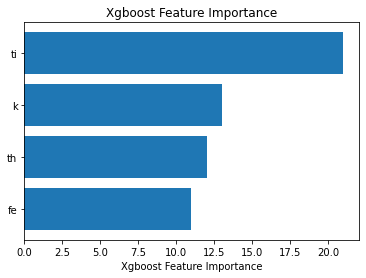

In [228]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
sorted_idx = data.score.argsort()
plt.barh(list(data_top.index), data.score[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.title("Xgboost Feature Importance")

This graph shows the importance of the different chemical compounds in the albedo prediction.

## Residual analisis

In [57]:
# Obtain residuals to plot and give correct shape:
df_pred=pd.DataFrame(y_pred, columns= ["albedo"])
residuals=y_test-df_pred
residuals=residuals.to_numpy()
residuals_plot=pd.DataFrame(data=residuals.reshape(360,360),index=np.arange(0,360,1), columns=np.arange(360,720,1))
residuals_plot_correct=residuals_plot.transpose()

* In the next chunk I give the correct shape to the predictions so as to plot them.

In [58]:
predictions=pd.DataFrame(data=y_pred.reshape(360,360),index=np.arange(0,360,1), columns=np.arange(360,720,1))
preds_correct=predictions.transpose()

#### 2-D Image of residuals

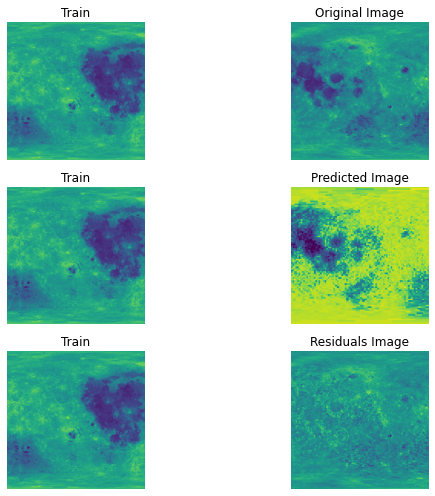

In [59]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 2
  
# First image
fig.add_subplot(rows, columns, 1)
  
plt.imshow(left_albedo)
plt.axis('off')
plt.title("Train")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(right_albedo)
plt.axis('off')
plt.title("Original Image")

# Second image
fig.add_subplot(rows, columns, 3)
  
plt.imshow(left_albedo)
plt.axis('off')
plt.title("Train")

fig.add_subplot(rows, columns, 4)
  
plt.imshow(preds_correct)
plt.axis('off')
plt.title("Predicted Image")

# Third image
fig.add_subplot(rows, columns, 5)
  
plt.imshow(left_albedo)
plt.axis('off')
plt.title("Train")

fig.add_subplot(rows, columns, 6)
  
plt.imshow(residuals_plot_correct)
plt.axis('off')
plt.title("Residuals Image")

fig.tight_layout()

plt.show()

From the visualization of the images we can see that the image of residuals shows the failure zones of our predictive model which is not able to correctly predict the response variable. In spite of this, the predictive model manages to capture the pattern of albedo variation very well even though there are areas of prediction failures that could be improved.

#### 1-D Histogram of residuals

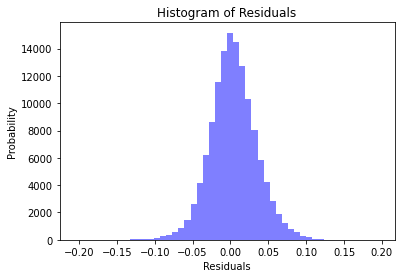

In [330]:
# Histogram of residuals
num_bins = 50

n, bins, patches = plt.hist(residuals, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Probability')
plt.title(r'Histogram of Residuals')

plt.show()

In [61]:
residuals2 = pd.DataFrame(residuals)
residuals2.describe()

,0
count,129600.000000
mean,0.003797
std,0.030974
min,-0.205407
25%,-0.015466
50%,0.002982
75%,0.022555
max,0.196515


In [336]:
print("Metrics in test set")
preds= y_pred
score=r2_score(y_test_sc,preds)
print("R2 socre =",score)
mse=mean_squared_error(y_test_sc,preds)
print("Mean square error =",mse)
rmse=np.sqrt(mean_squared_error(y_test_sc,preds))
print("Root mean squared error =",rmse)
evs=explained_variance_score(y_test_sc,preds)
print("Explained variance score =",evs)
mae=mean_absolute_error(y_test_sc,preds)
print("Mean absolute error =",mae)
mape=mean_absolute_percentage_error(y_test_sc,preds)
print("Mean absolute percentaje error =",mape)


Metrics in test set
R2 socre = 0.5670230413668282
Mean square error = 0.0009738120815640442
Root mean squared error = 0.031205962275886383
Explained variance score = 0.5734318535867038
Mean absolute error = 0.02393457120918508
Mean absolute percentaje error = 0.08381125891641383


In [337]:
y_train.describe()

,albedo
count,129600.000000
mean,0.285794
std,0.057578
min,0.096897
25%,0.258126
50%,0.303909
75%,0.324932
max,0.470428


By observing metrics such as the R2 and the explanted variance score, we can see that the predictive model manages to capture the variability of the response variable. Metrics such as the RMSE allow us to realize that on average the predicted results are not too far from those obtained, taking into account that the mean albedo is 0.285794 and its standard deviation is 0.057578. Another metric that helps us to interpret the situation is the MAPE value that obtains a value of 8%, which allows us to say that the average difference between the observed and the predicted is 8%.

# Task 2. Predicting Mercury’s elemental composition from Albedo with MESSENGER Data

In [110]:
# Import data
train = pd.read_csv(r"mercury-albedo-top-half.png.csv", header=None)
test = pd.read_csv(r"mercury-albedo-resized-bottom-half.png.csv", header=None)
al = pd.read_csv(r"alsimap_smooth_032015.png.csv", header=None)
ca = pd.read_csv(r"casimap_smooth_032015.png.csv", header=None)
fe = pd.read_csv(r"fesimap_smooth_032015.png.csv", header=None)
mg = pd.read_csv(r"mgsimap_smooth_032015.png.csv", header=None)
s = pd.read_csv(r"ssimap_smooth_032015.png.csv", header=None)
complete_albedo = train.append(test, ignore_index=True)

### Data visualization

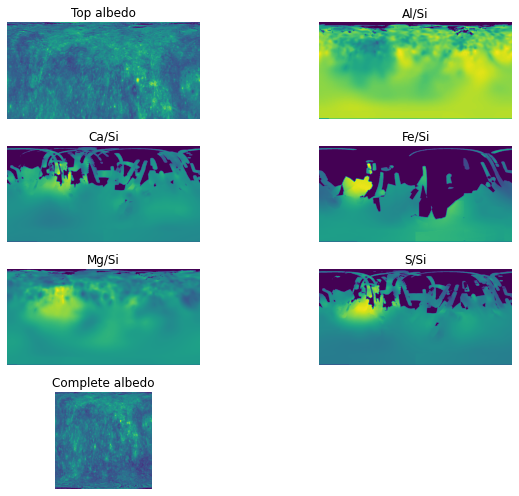

In [154]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(train)
plt.axis('off')
plt.title("Top albedo")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(al)
plt.axis('off')
plt.title("Al/Si")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(ca)
plt.axis('off')
plt.title("Ca/Si")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(fe)
plt.axis('off')
plt.title("Fe/Si")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(mg)
plt.axis('off')
plt.title("Mg/Si")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(s)
plt.axis('off')
plt.title("S/Si")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(complete_albedo)
plt.axis('off')
plt.title("Complete albedo")

fig.tight_layout()

plt.show()

## Predicting image gaps

    To predict the gaps in each of the databases, I am going to create a database containing complete information for all the variables and used it to train the model for one chemical compound. 
    From this trained model for one specific chemical compound the hyperparameters will be extrapolated to rest of the chemical compounds models, but the training procedure will be performed separately in each of the specific databases. 

In [90]:
train_df = pd.Series(train.values.ravel('F'))
test_df =  pd.Series(test.values.ravel('F'))
al_df =  pd.Series(al.values.ravel('F'))
ca_df =  pd.Series(ca.values.ravel('F'))
fe_df =  pd.Series(fe.values.ravel('F'))
mg_df =  pd.Series(mg.values.ravel('F'))
s_df =  pd.Series(s.values.ravel('F'))

#### Data bases creation

I create the database with all the completed observations: 

In [91]:
# Frame with complete observations for all components
complete_df_train = []
complete_df_test = []
for i in range(len(al_df)) :
    if train_df[i] != 0 and al_df[i] != 0 and ca_df[i] != 0 and fe_df[i] != 0 and mg_df[i] != 0 and s_df[i] != 0:
        complete_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        complete_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
        

complete_df_train=pd.DataFrame(complete_df_train, columns = ["albedo","al","ca","fe","mg","s","index"])

complete_df_test=pd.DataFrame(complete_df_test, columns = ["albedo","al","ca","fe","mg","s","index"])

I create the databases for each of the compounds:

In [92]:
al_df_train = []
al_df_test = []
for i in range(len(al_df)) :
    if al_df[i] == 0.0:
        al_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        al_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
        

al_df_train=pd.DataFrame(al_df_train, columns = ["albedo","al","ca","fe","mg","s","index"])
al_df_train_x = al_df_train[["albedo","ca","fe","mg","s","index"]]
al_df_train_y = al_df_train[["al"]]

al_df_test=pd.DataFrame(al_df_test, columns = ["albedo","al","ca","fe","mg","s","index"])
al_df_test_x = al_df_test[["albedo","ca","fe","mg","s","index"]]
al_df_test_y = al_df_test[["al"]]

In [93]:
ca_df_train = []
ca_df_test = []
for i in range(len(ca_df)) :
    if ca_df[i] == 0.0 :
        ca_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        ca_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
        
        
ca_df_train=pd.DataFrame(ca_df_train, columns = ["albedo","al","ca","fe","mg","s","index"])
ca_df_train_x = ca_df_train[["albedo","al","fe","mg","s","index"]]
ca_df_train_y = ca_df_train[["ca"]]

ca_df_test=pd.DataFrame(ca_df_test, columns = ["albedo","al","ca","fe","mg","s","index"])
ca_df_test_x = ca_df_test[["albedo","al","fe","mg","s","index"]]
ca_df_test_y = ca_df_test[["ca"]]

In [94]:
fe_df_train = []
fe_df_test = []
for i in range(len(fe_df)) :
    if fe_df[i] == 0.0 :
        fe_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        fe_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
        
        
fe_df_train=pd.DataFrame(fe_df_train, columns =["albedo","al","ca","fe","mg","s","index"])
fe_df_train_x = fe_df_train[["albedo","al","ca","mg","s","index"]]
fe_df_train_y = fe_df_train[["fe"]]

fe_df_test=pd.DataFrame(fe_df_test, columns =["albedo","al","ca","fe","mg","s","index"])
fe_df_test_x = fe_df_test[["albedo","al","ca","mg","s","index"]]
fe_df_test_y = fe_df_test[["fe"]]

In [95]:
mg_df_train = []
mg_df_test = []
for i in range(len(mg_df)) :
    if mg_df[i] == 0.0 :
        mg_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        mg_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])

mg_df_train=pd.DataFrame(mg_df_train, columns = ["albedo","al","ca","fe","mg","s","index"])
mg_df_train_x = mg_df_train[["albedo","al","ca","fe","s","index"]]
mg_df_train_y = mg_df_train[["mg"]]

mg_df_test=pd.DataFrame(mg_df_test, columns = ["albedo","al","ca","fe","mg","s","index"])
mg_df_test_x = mg_df_test[["albedo","al","ca","fe","s","index"]]
mg_df_test_y = mg_df_test[["mg"]]

In [96]:
s_df_train = []
s_df_test = []
for i in range(len(s_df)) :
    if s_df[i] == 0.0 :
        s_df_test.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
    else :
        s_df_train.append([train_df[i],al_df[i],ca_df[i],fe_df[i],mg_df[i],s_df[i],i])
        
s_df_train=pd.DataFrame(s_df_train, columns = ["albedo","al","ca","fe","mg","s","index"])
s_df_train_x = s_df_train[["albedo","al","ca","fe","mg","index"]]
s_df_train_y = s_df_train[["s"]]

s_df_test=pd.DataFrame(s_df_test, columns = ["albedo","al","ca","fe","mg","s","index"])
s_df_test_x = s_df_test[["albedo","al","ca","fe","mg","index"]]
s_df_test_y = s_df_test[["s"]]

### Linear corrleations

In [97]:
print("corrlation albedo/Al",al_df_train['albedo'].corr(al_df_train['al']))
print("corrlation albedo/Ca",ca_df_train['albedo'].corr(ca_df_train['ca']))
print("corrlation albedo/Fe",fe_df_train['albedo'].corr(fe_df_train['fe']))
print("corrlation albedo/Mg",mg_df_train['albedo'].corr(mg_df_train['mg']))
print("corrlation albedo/S",s_df_train['albedo'].corr(s_df_train['s']))

corrlation albedo/Al 0.0029103332206859146
corrlation albedo/Ca -0.0605852874510338
corrlation albedo/Fe 0.11947179429092479
corrlation albedo/Mg -0.02666021112851482
corrlation albedo/S -0.1027650163904538


As we can see the linear correlation between chemical compounds and albedo for mercury are notably lower than for the moon, so we will exclude the linear model to predict the data and employ the XGBoost algorithm.

### Predicting model for gaps

After having trained the model for the lunar albedo data, I will choose to use the same model that performed best on the database (XGBoost). To optimize the training time of all the models, as the values for the different databases are very similar I will train by Bayesian optimization to determine the hyperparameters for only one of the variables and use the same hyperparameters for the rest of the models, by doing this I will not incur in an error as the hyperparameters are not estimated from the data values. To estimate the hyperparameters I will use one random component (Fe/Si).

In [98]:
complete_df_train_x = complete_df_train[["albedo","al","ca","mg","s","index"]]
complete_df_train_y = complete_df_train[["fe"]]

complete_df_test_x = complete_df_test[["albedo","al","ca","mg","s","index"]]
complete_df_test_y = complete_df_test[["fe"]]

In [99]:
complete_df_train_x2 = complete_df_train_x.drop(["index"], axis=1)

In [206]:
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,20),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (1.0, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 5)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, complete_df_train_x2, complete_df_train_y, cv=5, scoring='neg_root_mean_squared_error'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [66]:
# optimizer.maximize(init_points=10, n_iter=5)

In [208]:
optimizer.max

{'target': -0.07981687044636764,
 'params': {'colsample': 1.0,
  'gamma': 3.6016224672107904,
  'learning_rate': 0.010113231069171438,
  'max_depth': 8.139653734741277,
  'n_estimators': 232.08030173540175,
  'subsample': 1.0}}

In [100]:
model_fe = XGBRegressor(n_estimators=232,
                     max_depth=8,
                     subsample=1,
                    learning_rate=0.01,
                    gamma = 3.6)

model_al = XGBRegressor(n_estimators=232,
                     max_depth=8,
                     subsample=1,
                    learning_rate=0.01,
                    gamma = 3.6)

model_ca = XGBRegressor(n_estimators=232,
                     max_depth=8,
                     subsample=1,
                    learning_rate=0.01,
                    gamma = 3.6)

model_mg = XGBRegressor(n_estimators=232,
                     max_depth=8,
                     subsample=1,
                    learning_rate=0.01,
                    gamma = 3.6)

model_s = XGBRegressor(n_estimators=232,
                     max_depth=8,
                     subsample=1,
                    learning_rate=0.01,
                    gamma = 3.6)

Here I delete the column containing the index so that the model is not trained thinking that it is an independent variable, but this column is extremely necessary to reconstruct the images after modeling, for this reason I define secondary databases.

In [101]:
# Took index column out of data frame, so as not to train with it
fe_df_train_x2 = fe_df_train_x.drop(["index"], axis=1)
al_df_train_x2 = al_df_train_x.drop(["index"], axis=1)
ca_df_train_x2 = ca_df_train_x.drop(["index"], axis=1)
mg_df_train_x2 = mg_df_train_x.drop(["index"], axis=1)
s_df_train_x2 = s_df_train_x.drop(["index"], axis=1)

In [102]:
# fit model para cada uno de los distintos modelos.
model_fe.fit(fe_df_train_x2, fe_df_train_y)
model_al.fit(al_df_train_x2, al_df_train_y)
model_ca.fit(ca_df_train_x2, ca_df_train_y)
model_mg.fit(mg_df_train_x2, mg_df_train_y)
model_s.fit(s_df_train_x2, s_df_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=3.6, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=232, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [103]:
# Took index column out of data frame to make predictions
fe_df_test_x2 = fe_df_test_x.drop(["index"], axis=1)
al_df_test_x2 = al_df_test_x.drop(["index"], axis=1)
ca_df_test_x2 = ca_df_test_x.drop(["index"], axis=1)
mg_df_test_x2 = mg_df_test_x.drop(["index"], axis=1)
s_df_test_x2 = s_df_test_x.drop(["index"], axis=1)

In [104]:
# make predictions for test data
y_pred_fe = model_fe.predict(fe_df_test_x2)
y_pred_al = model_al.predict(al_df_test_x2)
y_pred_ca = model_ca.predict(ca_df_test_x2)
y_pred_mg = model_mg.predict(mg_df_test_x2)
y_pred_s = model_s.predict(s_df_test_x2)

In [105]:
# Now i use the index so as to re ubicate the observations
y_pred_fe = pd.DataFrame({
    'prediction': y_pred_fe})
y_pred_fe = y_pred_fe.join(fe_df_test_x["index"])

y_pred_al = pd.DataFrame({
    'prediction': y_pred_al})
y_pred_al = y_pred_al.join(al_df_test_x["index"])

y_pred_ca = pd.DataFrame({
    'prediction': y_pred_ca})
y_pred_ca = y_pred_ca.join(ca_df_test_x["index"])

y_pred_mg = pd.DataFrame({
    'prediction': y_pred_mg})
y_pred_mg = y_pred_mg.join(mg_df_test_x["index"])

y_pred_s = pd.DataFrame({
    'prediction': y_pred_s})
y_pred_s = y_pred_s.join(s_df_test_x["index"])

Now I enter the predicted data into each of the databases in order to plot them:

In [107]:
al_df =  pd.Series(al.values.ravel('F'))
ca_df =  pd.Series(ca.values.ravel('F'))
fe_df =  pd.Series(fe.values.ravel('F'))
mg_df =  pd.Series(mg.values.ravel('F'))
s_df =  pd.Series(s.values.ravel('F'))

In [108]:
aux_pred=y_pred_fe.to_numpy() 
for i in range(len(aux_pred)):
    fe_df[aux_pred[i][1]] = aux_pred[i][0]
    
aux_pred=y_pred_al.to_numpy() 
for i in range(len(aux_pred)):
    al_df[aux_pred[i][1]] = aux_pred[i][0]
    
aux_pred=y_pred_ca.to_numpy() 
for i in range(len(aux_pred)):
    ca_df[aux_pred[i][1]] = aux_pred[i][0]
    
aux_pred=y_pred_mg.to_numpy() 
for i in range(len(aux_pred)):
    mg_df[aux_pred[i][1]] = aux_pred[i][0]
    
aux_pred=y_pred_s.to_numpy() 
for i in range(len(aux_pred)):
    s_df[aux_pred[i][1]] = aux_pred[i][0]

I format the predicted database correctly for plotting:

In [109]:
fe_df=fe_df.to_numpy()
fe_plot=pd.DataFrame(data=fe_df.reshape(1440, 720))
fe_plot=fe_plot.transpose()

al_df=al_df.to_numpy()
al_plot=pd.DataFrame(data=al_df.reshape(1440, 720))
al_plot=al_plot.transpose()

ca_df=ca_df.to_numpy()
ca_plot=pd.DataFrame(data=ca_df.reshape(1440, 720))
ca_plot=ca_plot.transpose()

mg_df=mg_df.to_numpy()
mg_plot=pd.DataFrame(data=mg_df.reshape(1440, 720))
mg_plot=mg_plot.transpose()

s_df=s_df.to_numpy()
s_plot=pd.DataFrame(data=s_df.reshape(1440, 720))
s_plot=s_plot.transpose()


### Plotting imputed images (with out gaps):

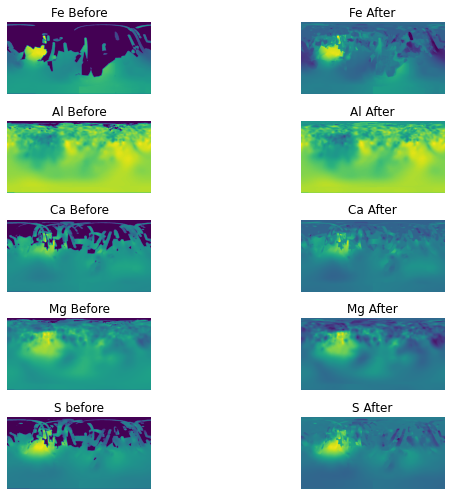

In [111]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 5
columns = 2
  
# First image
fig.add_subplot(rows, columns, 1)
  
plt.imshow(fe)
plt.axis('off')
plt.title("Fe Before")

fig.add_subplot(rows, columns, 2)
  
plt.imshow(fe_plot)
plt.axis('off')
plt.title("Fe After")

# Second image
fig.add_subplot(rows, columns, 3)
  
plt.imshow(al)
plt.axis('off')
plt.title("Al Before")
  
fig.add_subplot(rows, columns, 4)
  
plt.imshow(al_plot)
plt.axis('off')
plt.title("Al After")

# Third image
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(ca)
plt.axis('off')
plt.title("Ca Before")
  
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(ca_plot)
plt.axis('off')
plt.title("Ca After")
  
# Fourth image
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(mg)
plt.axis('off')
plt.title("Mg Before")

fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(mg_plot)
plt.axis('off')
plt.title("Mg After")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(s)
plt.axis('off')
plt.title("S before")

fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(s_plot)
plt.axis('off')
plt.title("S After")

fig.tight_layout()

plt.show()

# Predicting quimical components for test set in the bottom half of the planet using the albedo

* As the database is very large, in order to optimize the training time of the different models to predict the chemical compounds, I will use the same hyperparameters as those tuned above to predict the gaps. Again no error is incurred as the databases are practically similar and the hyperparameters do not depend on the data values. In other words, the hyperparameters are the same but the databases on which they are trained are not. I will proceed to fit the same model won for the individual response of each of the chemical compounds using albedo as an independent variable. 

In [83]:
# fit model para cada uno de los distintos compuestos quimicos
model_fe.fit(fe_df_train_x2["albedo"], fe_df_train_y)
model_al.fit(al_df_train_x2["albedo"], al_df_train_y)
model_ca.fit(ca_df_train_x2["albedo"], ca_df_train_y)
model_mg.fit(mg_df_train_x2["albedo"], mg_df_train_y)
model_s.fit(s_df_train_x2["albedo"], s_df_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=3.6, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=232, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [84]:
# make predictions for test data
y_pred_fe = model_fe.predict(test_df)
y_pred_al = model_al.predict(test_df)
y_pred_ca = model_ca.predict(test_df)
y_pred_mg = model_mg.predict(test_df)
y_pred_s = model_s.predict(test_df)

In [85]:
y_pred_fe = np.array(y_pred_fe)
fe_plot=pd.DataFrame(data=y_pred_fe.reshape(1440, 720))
fe_plot=fe_plot.transpose()

y_pred_al = np.array(y_pred_al)
al_plot=pd.DataFrame(data=y_pred_al.reshape(1440, 720))
al_plot=al_plot.transpose()

y_pred_ca = np.array(y_pred_ca)
ca_plot=pd.DataFrame(data=y_pred_ca.reshape(1440, 720))
ca_plot=ca_plot.transpose()

y_pred_mg = np.array(y_pred_mg)
mg_plot=pd.DataFrame(data=y_pred_mg.reshape(1440, 720))
mg_plot=mg_plot.transpose()

y_pred_s = np.array(y_pred_s)
s_plot=pd.DataFrame(data=y_pred_s.reshape(1440, 720))
s_plot=s_plot.transpose()

### Plot predicted chemical compounds for the bottom half of the planet using the albedo

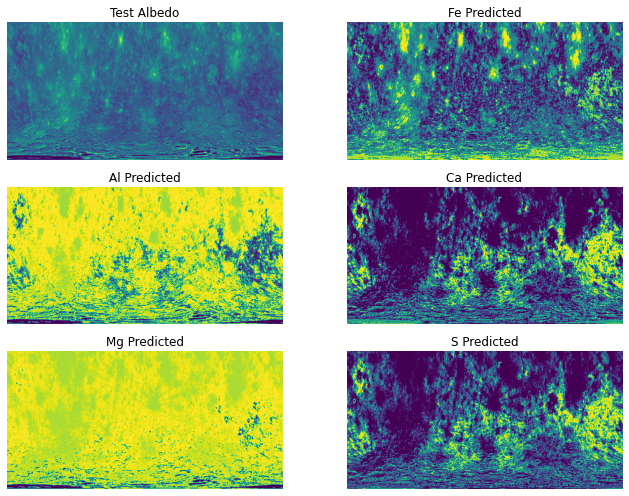

In [86]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 2
  
# First image
fig.add_subplot(rows, columns, 1)
  
plt.imshow(test)
plt.axis('off')
plt.title("Test Albedo")

# Second image
fig.add_subplot(rows, columns, 2)
  
plt.imshow(fe_plot)
plt.axis('off')
plt.title("Fe Predicted")

# Third image
fig.add_subplot(rows, columns, 3)
  
plt.imshow(al_plot)
plt.axis('off')
plt.title("Al Predicted")

# Fourth image
fig.add_subplot(rows, columns, 4)
  
plt.imshow(ca_plot)
plt.axis('off')
plt.title("Ca Predicted")

# Fifth image
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(mg_plot)
plt.axis('off')
plt.title("Mg Predicted")
  
# Sixth image
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(s_plot)
plt.axis('off')
plt.title("S Predicted")

fig.tight_layout()

plt.show()